In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import mdtraj as md
import mcg
import h5py
import pandas as pd
import matplotlib_config as cfg
import fnmatch
from matplotlib import cm
from matplotlib.colors import PowerNorm

In [2]:
step2us = 2e-9
burst = 1e5

In [3]:
datafolders =['data_mu175_chain0_batch_0/', 'data_mu175_chain1_batch_0/', 'data_mu175_chain1_batch_1/', 'data_mu175_chain1_batch_2/']
#folder = 'archive/wrong_wrapping/data_mu180'
gro_folder = 'gro_files'

In [4]:
top_file = os.path.join(gro_folder, 'conf.gro')

In [5]:
def build_pd(run_folder_path):
    logfile_path = os.path.join(run_folder_path, 'log.txt')
    weights = np.load(os.path.join(run_folder_path, 'trajectory_weights.npy'))[1:]
    
    # Load the log file
    df = pd.read_fwf(
        logfile_path,
        header=0,
        widths=[21] * 7,
        strip=True
    )
    df.columns = df.columns.str.strip()
    
    # Initialize weights column with zeros
    df['Weights'] = 0.0
    
    # Get successful rows
    successful_indices = df[df['Successful'] == True].index
    
    # Sanity check
    assert len(successful_indices) == len(weights), "Mismatch between successful trajectories and weights"
    
    # Assign weights to successful trajectories
    for idx, weight in zip(successful_indices, weights):
        df.at[idx, 'Weights'] = weight

    return df

In [6]:

# Dictionary to store all run data
run_data = {}

for datafolder in datafolders:
    print(datafolder)
    run_data[datafolder] = {}
    
    for run_folder in os.listdir(datafolder):
        run_folder_path = os.path.join(datafolder, run_folder)
        
        # Skip non-directories and hidden folders
        if not os.path.isdir(run_folder_path) or run_folder.startswith('.'):
            continue
        
        # Initialize entry for this run
        run_data[datafolder][run_folder] = {
            'log': None,
            'index_succ': {},
            'trial_rej': {},
            'cages': {}
        }
        
        df = build_pd(run_folder_path)
        run_data[datafolder][run_folder]['log'] = df
        
        # Process successful trials
        for succ_file in os.listdir(run_folder_path):
            if succ_file.startswith('cv_') and not succ_file.endswith('_0.txt'):
                try:
                    trial_num = int(succ_file.split('_')[1].split('.')[0])
                    trial_path = os.path.join(run_folder_path, succ_file)
                    frames, mcg_values = np.loadtxt(trial_path, skiprows=1, unpack=True)

                    cutoff_mask = mcg_values >= 300
                    B_cutoff = int(frames[np.argmax(cutoff_mask)] / burst) if np.any(cutoff_mask) else None

                    run_data[datafolder][run_folder]['index_succ'][trial_num] = {
                        'frames': frames,
                        'mcg_values': mcg_values,
                        'B_cutoff': B_cutoff,
                        'file_path': os.path.join(run_folder_path, f'traj_{trial_num}.dcd')
                    }

                    parts = ['cages']
                    parts.extend(datafolder.split('_')[1:])
                    cagefolder = '_'.join(parts)



                    times, _, Cages_512, Cages_62512, Cages_64512, Cages_4151062, _ = np.loadtxt(f'{cagefolder}/{run_folder}/traj_{trial_num}_stride_200_grade.txt', skiprows = 1, unpack = True)

                    run_data[datafolder][run_folder]['cages'][trial_num] = {
                    'frames': times,
                    '512': Cages_512,
                    '62512': Cages_62512,
                    '64512': Cages_64512,
                    '4151062': Cages_4151062
                    }

                except (ValueError, IndexError) as e:
                    print(f"Error processing {succ_file} in {run_folder}: {e}")
                    continue
                
    
        
        # Process rejected trials
        for rej_file in os.listdir(run_folder_path):
            if rej_file.startswith('rejected_cv_trial_') and not rej_file.endswith('_0.txt'):
                try:
                    trial_num = int(rej_file.split('_')[3].split('.')[0])
                    trial_path = os.path.join(run_folder_path, rej_file)
                    frames, mcg_values = np.loadtxt(trial_path, skiprows=1, unpack=True)

                    run_data[datafolder][run_folder]['trial_rej'][trial_num] = {
                        'frames': frames,
                        'mcg_values': mcg_values
                    }

                except (ValueError, IndexError) as e:
                    print(f"Error processing {rej_file} in {run_folder}: {e}")
                    continue
        


data_mu175_chain0_batch_0/
data_mu175_chain1_batch_0/
data_mu175_chain1_batch_1/
data_mu175_chain1_batch_2/


In [7]:
with open("successful_shooting_frames.txt", "w") as f:
    for dataset in run_data:
        for run in run_data[dataset]:
            f.write(f'{dataset}, {run}\n')
            df = run_data[dataset][run]['log']
            df_successful = df[df['Successful'] == True]

            o = df_successful['SP frame on old traj'].values
            n = df_successful['SP frame on new traj'].values
            directions = df_successful['Shooting Direction'].values

            for i in range(len(df_successful)):
                f.write(f"{o[i]}\t{n[i]}\t{directions[i]}\n")

In [8]:
chain1_folders =['data_mu175_chain1_batch_0/', 'data_mu175_chain1_batch_1/', 'data_mu175_chain1_batch_2/']

In [9]:

def find_age_of_oldest_path(indices, directions, lengths):
    '''
        Parameters:
            indices : list of tuples
                (old_index, new_index) are shooting point indices on the old and new path
            directions : list of int
                (+1 = forward shooting, -1 = backward shooting)
            first_path_length : int
                Length of the initial transition path (number of frames)

        Returns:
            AOPS_list : list of int
                Ages (in number of accepted paths) of the oldest path segment for each starting trajectory
            LOPS_list : list of lists
                Evolution of the oldest path segment lengths over successive accepted paths.
                Each sublist corresponds to one starting position in AOPS_list.
    '''

    LOPS_list = []  #lengths of oldest path segments
    AOPS_list = []  #ages of oldest path segments
    
    # loop over all possible paths as starting paths
    for start in range(1, len(indices)):    #oldest path is only defined once another path has been accepted (so starts at idx 1)
        first_path_length = lengths[start - 1]
        
        # Setting up the first OPS after one new path has been generated
        _, first_path_n = indices[start - 1]    #shooting point index on new path
        first_path_dir = directions[start - 1]

        if first_path_dir == 1:
            SOPS = 0                    #SOPS (Start of oldest path segment) and EOPS (end of oldest path segment) are always defined in terms of the indices on the newest path
            EOPS = first_path_n
    
        if first_path_dir == -1:
            SOPS = first_path_n
            EOPS = first_path_length
    
    
        LOPS = EOPS - SOPS
        current_lengths = [LOPS]
        age = 1
    
    
        for idx, (o, n) in enumerate(indices[start:], start = start):       #(o, n) are sp indices on old/new path
    
            if directions[idx] == 1:        #easier version, no shift of indices necessary
                print(f'n{n}')
                print(EOPS)
                if n <= EOPS:
                    EOPS = n
                #otherwise the end stays where it was before
        
            elif directions[idx] == -1:     #indices need to be shifted
                shift = n - o
                if o >= SOPS:
                    SOPS = n
                    EOPS += shift
                else:                        # length stays the same but indices need to be shifted to fit current path 
                    SOPS += shift
                    EOPS += shift
    
            LOPS = EOPS - SOPS

            #when path dies
            if LOPS <= 0:
                AOPS_list.append(age)
                LOPS_list.append(current_lengths)
                break
                
            age += 1
            current_lengths.append(LOPS)
        else:  # OPS survived all paths
            break  # Stop early since following starts will also survive

    return AOPS_list, LOPS_list

In [10]:
ages_of_oldest_paths = []
lengths_of_oldest_path = []

with open("successful_shooting_frames.txt", "w") as f:
    for run_idx in range(11):
        run = f'run_{run_idx}'
        f.write(f'{dataset}, {run}\n')

        print(f'run idx {run_idx}')

        indices = []
        all_directions = []
        all_lengths = []
        
        for dataset in chain1_folders:
            

            #print(f'{dataset}, {run}\n')

            
            df = run_data[dataset][run]['log']
            df_successful = df[df['Successful'] == True]

            o = df_successful['SP frame on old traj'].values
            n = df_successful['SP frame on new traj'].values

            #np.append(indices, np.column_stack((o, n)))

            indices.extend(zip(o, n))

            
            directions = df_successful['Shooting Direction'].values
            lengths = df_successful['Full Path Length'].values * burst

            all_directions.extend(directions)
            all_lengths.extend(lengths)

        for i in range(len(df_successful)):
            f.write(f"{o[i]}\t{n[i]}\t{directions[i]}\t{lengths[i]}\n")

        AOPS, LFOPS = find_age_of_oldest_path(indices, all_directions, all_lengths)
        #print(AOPS)
        #print(LFOPS)

        #print(f'len {len(indices)}')
        #print(f'aops {AOPS} \nlfops {LFOPS}')

        ages_of_oldest_paths.extend(AOPS)
        lengths_of_oldest_path.extend(LFOPS)


run idx 0
n85900000
86500000
n70900000
78900000
n80500000
70900000
n26900000
27700000
n69200000
22200000
n51000000
32700000
n87800000
32700000
n80700000
32700000
n75400000
32700000
n85900000
160100000.0
n70900000
78900000
n80500000
70900000
n26900000
27700000
n69200000
22200000
n51000000
32700000
n87800000
32700000
n80700000
32700000
n75400000
32700000
n70900000
78900000
n80500000
70900000
n26900000
27700000
n69200000
22200000
n51000000
32700000
n87800000
32700000
n80700000
32700000
n75400000
32700000
n70900000
107200000.0
n80500000
70900000
n26900000
27700000
n69200000
22200000
n51000000
32700000
n87800000
32700000
n80700000
32700000
n75400000
32700000
n80500000
70900000
n26900000
27700000
n69200000
22200000
n51000000
32700000
n87800000
32700000
n80700000
32700000
n75400000
32700000
n26900000
37300000
n69200000
22200000
n51000000
32700000
n87800000
32700000
n80700000
32700000
n75400000
32700000
n26900000
75500000.0
n69200000
22200000
n51000000
32700000
n87800000
32700000
n80700000
327

In [11]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size//2:]

In [12]:
def autocorrelation(x):
    x = np.array(x)
    x = x - np.mean(x)
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:] / np.var(x) / len(x)

In [13]:

def acf(x, max_lag=None):
    """
    Calculate the Autocorrelation Function (ACF) of a 1-dimensional sequence.

    Parameters:
        x (array_like): Input sequence.
        max_lag (int, optional): Maximum lag to compute. Default is len(x)-1.
        method (str, optional): 'direct' or 'fft'. If None, chooses automatically.

    Returns:
        numpy.ndarray: ACF values from lag 0 to `max_lag`.
    """
    x = np.array(x, dtype=np.float64)
    n = len(x)
    if n == 0:
        return np.array([])
    if max_lag is None:
        max_lag = n - 1
    else:
        max_lag = min(int(max_lag), n - 1)
    
    # Subtract mean and check for constant series
    x = x - np.mean(x)
    denom_total = np.sum(x**2)  # Total variance (denominator)
    
    # Handle constant series
    if denom_total < 1e-12:
        acf_vals = np.zeros(max_lag + 1)
        if max_lag >= 0:
            acf_vals[0] = 1.0
        return acf_vals

        
    corr = np.correlate(x, x, mode='full')
    start_index = n - 1
    end_index = start_index + max_lag + 1
    acf_vals = corr[start_index:end_index]
    acf_vals = acf_vals / denom_total  # Normalize
    return acf_vals
    


In [14]:
def multi_run_acf(runs, max_lag=None):
    """
    Calculate averaged ACF for multiple time series of varying lengths.
    
    Parameters:
        runs (list of arrays): Time series with different lengths
        max_lag (int): Maximum lag to compute (default: longest series - 1)
    
    Returns:
        avg_acf (array): Average ACF values for lags 0 to max_lag
        counts (array): Number of series used at each lag
    """
    if not runs:
        return np.array([]), np.array([])
    
    # Set maximum lag if not specified
    if max_lag is None:
        max_lag = max(len(run) for run in runs) - 1
    
    # Precompute ACF for each series
    all_acfs = []
    for run in runs:
        n = len(run)
        if n == 0:
            all_acfs.append(np.array([]))
            continue
            
        # Compute ACF up to min(series_length, max_lag)
        run_max_lag = min(n - 1, max_lag)
        run_acf = acf(run, max_lag=run_max_lag)
        all_acfs.append(run_acf)
    
    # Initialize output arrays
    avg_acf = np.full(max_lag + 1, np.nan)
    counts = np.zeros(max_lag + 1, dtype=int)
    std_error = np.full(max_lag + 1, np.nan)
    
    # Average ACF values at each lag
    for k in range(max_lag + 1):
        values = []
        for acf_vals in all_acfs:
            if k < len(acf_vals):
                values.append(acf_vals[k])
                
        if values:
            avg_acf[k] = np.mean(values)
            counts[k] = len(values)
            std_error[k] = np.std(values) / np.sqrt(len(values))
            
    return avg_acf, counts, std_error

In [15]:
avg_acf, counts, std_error = multi_run_acf(lengths_of_oldest_path)

In [16]:
plt.rcParams.update({
    'font.size': 18,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 14,
    'legend.frameon': False
})


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


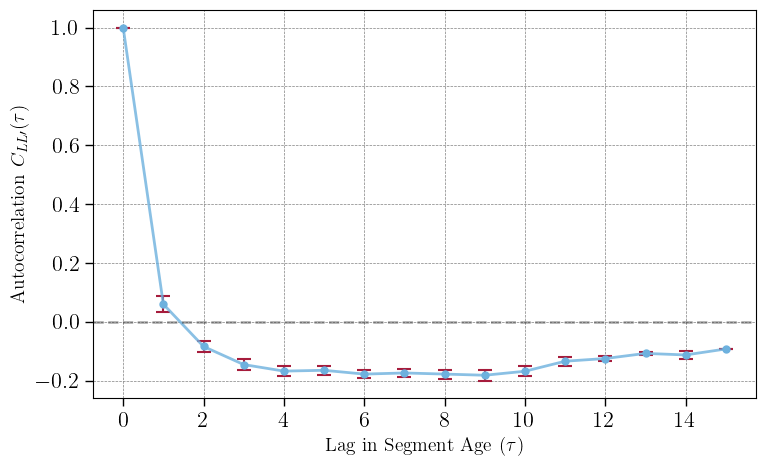

In [17]:
fig, ax = plt.subplots(figsize=(8, 5))

x = np.arange(len(avg_acf))
    
ax.errorbar(x, avg_acf, yerr=std_error, 
            fmt='o',  # Format: marker + line style
            ms = 5,
            color=cfg.colors['lightblue'],
            ecolor=cfg.colors['red'],  # Error bar color
            elinewidth=1.5,  # Error bar line width
            capsize=5,
            capthick=1.5)

ax.plot(x, avg_acf, c = cfg.colors['lightblue'], alpha = 0.8)

if any(avg_acf < 0) and any(avg_acf > 0):
    ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)

ax.set_xlabel(r'Lag in Segment Age ($\tau$)')
ax.set_ylabel(r'Autocorrelation $C_{LL\prime}(\tau)$')
plt.tight_layout()

plt.legend()

#plt.savefig(f'figures/oldest_path_segment_length_acf.png')

In [18]:
def average_length(length_list):

    max_elements = np.max([len(x) for x in length_list])
    
    avg_length = np.full(max_elements, np.nan)
    std_error = np.full(max_elements, np.nan)
    
    # Average ACF values at each lag
    for k in range(max_elements):
        values = []
        for lengths_one_run in length_list:
            if k < len(lengths_one_run):
                values.append(lengths_one_run[k])
                
        if values:
            avg_length[k] = np.mean(values)
            std_error[k] = np.std(values) / np.sqrt(len(values) -1)
            
    return avg_length, std_error

In [19]:
max_len = max(len(sublist) for sublist in lengths_of_oldest_path)
L = [sublist + [0] * (max_len - len(sublist)) for sublist in lengths_of_oldest_path]

Ls_padded = np.array(L)

In [20]:
N = Ls_padded.shape[1]
avg_length_padded = np.mean(Ls_padded, axis = 0) * step2us
std_error_padded = np.std(Ls_padded, axis = 0)  * step2us  / np.sqrt(N)

avg_age = np.mean(ages_of_oldest_paths)

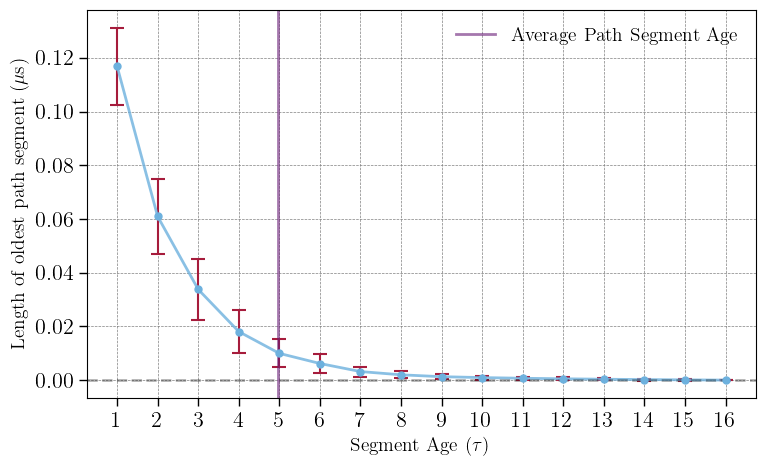

In [21]:
fig, ax = plt.subplots(figsize=(8, 5))

x = np.arange(len(avg_length_padded)) + 1
    
ax.errorbar(x, avg_length_padded, yerr=std_error_padded, 
            fmt='o',  # Format: marker + line style
            ms = 5,
            color=cfg.colors['lightblue'],
            ecolor=cfg.colors['red'],  # Error bar color
            elinewidth=1.5,  # Error bar line width
            capsize=5,
            capthick=1.5)

ax.plot(x, avg_length_padded, c = cfg.colors['lightblue'], alpha = 0.8)


ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)

ax.axvline(x = avg_age, color=cfg.colors['purple'], linestyle='-', alpha=0.6, label = 'Average Path Segment Age')

ax.set_xlabel(r'Segment Age ($\tau$)')
ax.set_ylabel(r'Length of oldest path segment ($\mathrm{\mu s}$)')
ax.set_xticks(x)
plt.tight_layout()

plt.legend()

#plt.savefig(f'figures/oldest_path_segment_length.png')

In [22]:
avg_length, std_error = average_length(lengths_of_oldest_path) 

avg_length *= step2us
std_error *= step2us

/scratch_local/ipykernel_919859/1988475842.py:17: RuntimeWarning: invalid value encountered in scalar divide
  std_error[k] = np.std(values) / np.sqrt(len(values) -1)


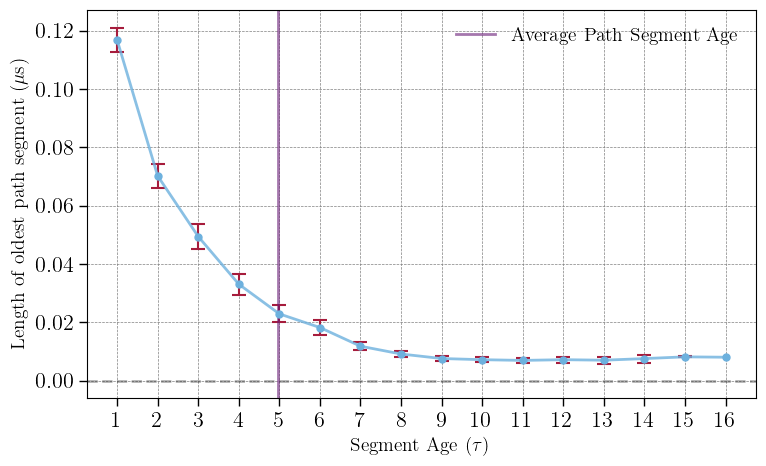

In [23]:
fig, ax = plt.subplots(figsize=(8, 5))

x = np.arange(len(avg_length)) + 1
    
ax.errorbar(x, avg_length, yerr=std_error, 
            fmt='o',  # Format: marker + line style
            ms = 5,
            color=cfg.colors['lightblue'],
            ecolor=cfg.colors['red'],  # Error bar color
            elinewidth=1.5,  # Error bar line width
            capsize=5,
            capthick=1.5)

ax.plot(x, avg_length, c = cfg.colors['lightblue'], alpha = 0.8)


ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)

ax.axvline(x = avg_age, color=cfg.colors['purple'], linestyle='-', alpha=0.6, label = 'Average Path Segment Age')

ax.set_xlabel(r'Segment Age ($\tau$)')
ax.set_ylabel(r'Length of oldest path segment ($\mathrm{\mu s}$)')
ax.set_xticks(x)
plt.tight_layout()

plt.legend()

#plt.savefig(f'figures/oldest_path_segment_length_only_alive.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


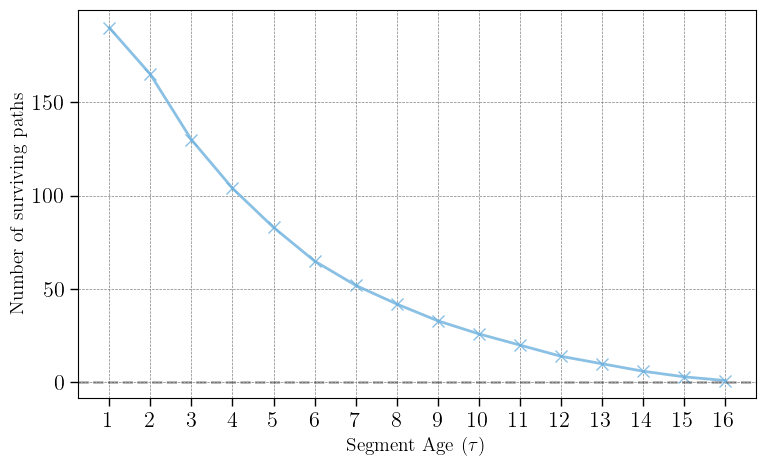

In [24]:
fig, ax = plt.subplots(figsize=(8, 5))

x = np.arange(len(avg_length)) + 1
    
ax.plot(x, counts, c = cfg.colors['lightblue'], alpha = 0.8, marker = 'x')


ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)

#ax.axvline(x = avg_age, color=cfg.colors['purple'], linestyle='-', alpha=0.6, label = 'Average Path Segment Age')

ax.set_xlabel(r'Segment Age ($\tau$)')
ax.set_ylabel(r'Number of surviving paths')
ax.set_xticks(x)
plt.tight_layout()

plt.legend()

#plt.savefig(f'figures/oldest_path_segment_length.png')

In [25]:
plt.rcParams.update({
    'font.size': 18,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 14,
    'legend.frameon': False
})

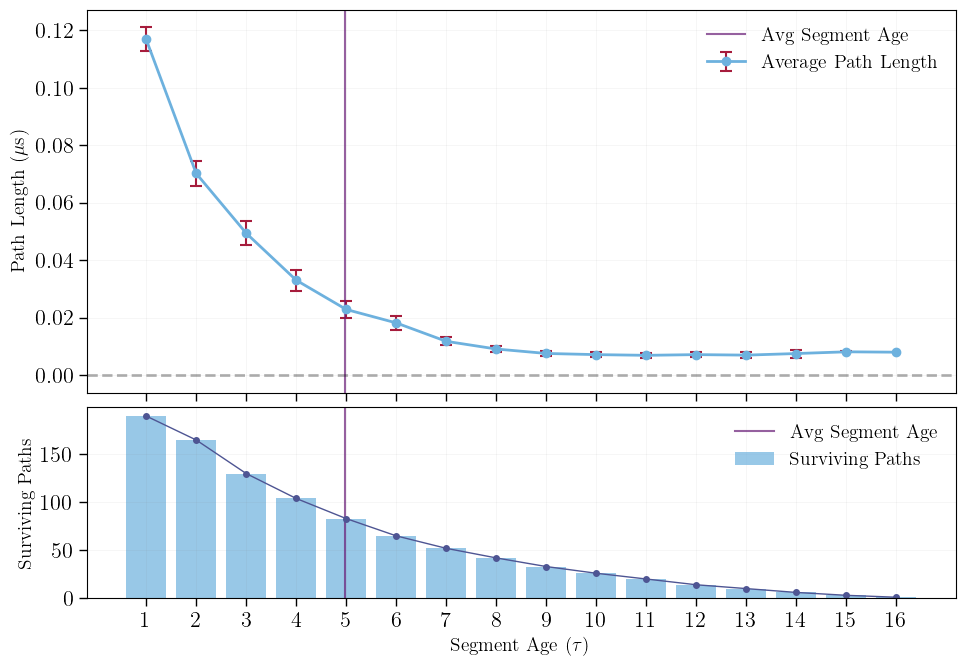

In [26]:
# Create figure with two vertically stacked subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), 
                               sharex=True, 
                               gridspec_kw={'height_ratios': [2, 1]})

x = np.arange(len(avg_length)) + 1

# Top plot: Average path length
ax1.errorbar(x, avg_length, yerr=std_error, fmt='o-', ms=6,
             color=cfg.colors['lightblue'], ecolor=cfg.colors['red'],
             elinewidth=1.5, capsize=4, capthick=1.5,
             label='Average Path Length')

# Add average age reference line to both plots
for ax in (ax1, ax2):
    ax.axvline(x=avg_age, color=cfg.colors['purple'], linestyle='-', 
               alpha=0.7, linewidth=1.5, label='Avg Segment Age')
    ax.grid(alpha=0.1, linestyle='-')

# Bottom plot: Surviving path count
ax2.bar(x, counts, color=cfg.colors['lightblue'], alpha=0.7,
        label='Surviving Paths')
ax2.plot(x, counts, 'o-', color=cfg.colors['darkblue'], markersize=4, linewidth=1)

# Add zero reference line to top plot
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3)

# Configure axes
ax1.set_ylabel(r'Path Length ($\mathrm{\mu s}$)')
ax2.set_ylabel('Surviving Paths')
ax2.set_xlabel(r'Segment Age ($\tau$)')

# Set xticks explicitly for both plots
for ax in (ax1, ax2):
    ax.set_xticks(x)
    ax.set_xticklabels([str(int(i)) for i in x])

# Add legends in non-overlapping positions
ax1.legend(loc='best', framealpha=0.8)
ax2.legend(loc='best', framealpha=0.8)

# Adjust spacing and layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.05)  # Minimal space between plots

# Save
#plt.savefig('figures/path_length_analysis_aligned.png', dpi=300)
plt.show()